### 3D cyl

In [1]:
import os
import time

import sys

benchmark_path = '../BenchmarkData/'
sys.path.append('../')

from ofelia.aux_obj import *

import matplotlib.pyplot as plt
from matplotlib import cm

from constants import *

import numpy as np
import gmsh

Setting OpenMC materials

In [2]:
#configure cross sections
# openmc.config["cross_sections"]="/home/neutron/OpenMC/cross_sections/endfb-viii.0-hdf5/cross_sections.xml"

#HERE WE SHOULD BUILD THE MATERIALS
# from ofelia.constants import *
#from ofelia.materials import * # importing parameters and OpenMC materials
from materials import *

path_res = './results_'+str(n_div)+'div_'+str(Power/1000)+'kW/'
if not os.path.exists(path_res):
    os.system("mkdir "+path_res)

print('The number of axial divisions is '+ str(n_div))
print('The pin power is set to ' +str(Power/1000)+' kW')

xml_materials = updateXML(mat_dict, n_div)

The number of axial divisions is 8
The pin power is set to 65.0 kW


### Create gmsh geometry

In [3]:
vol_markers = [1000,1001,1002]
surf_markers = [10]

In [4]:
mesh_factor = 0.003

center_x = 0
center_y = 0
base_z = -l_active/2

In [5]:
path_mesh = '../mesh/'
os.makedirs(path_mesh, exist_ok=True)

if os.path.exists(path_mesh+"cyl3D.msh") == False:

    gmsh.initialize()
    gmsh.clear()

    tag = 1
    cyl1 = gmsh.model.occ.addCylinder(center_x,center_y,base_z,0,0,l_active, fuel_or, tag = tag) #fuel
    tag += 1

    cyl2 = gmsh.model.occ.addCylinder(center_x,center_y,base_z,0,0,l_active, clad_ir, tag = tag) #outer gap
    tag += 1

    cyl3 = gmsh.model.occ.addCylinder(center_x,center_y,base_z,0,0,l_active, clad_or, tag = tag) #outer clad
    tag += 1

    #clad
    cyl4 = gmsh.model.occ.addCylinder(center_x,center_y,base_z,0,0,l_active, clad_ir, tag = tag) #outer gap
    tag += 1


    #fuel
    fuel = gmsh.model.occ.addCylinder(center_x,center_y,base_z,0,0,l_active, fuel_or, tag = tag)
    tag += 1


    #gap
    gmsh.model.occ.cut([(3,cyl2)],[(3,cyl1)],tag = tag)
    gap = tag
    tag += 1


    #clad
    gmsh.model.occ.cut([(3,cyl3)],[(3,cyl4)],tag = tag)
    clad = tag
    tag += 1

    #sync required to get vol and surfaces
    gmsh.model.occ.synchronize()

    gmsh.model.occ.removeAllDuplicates()

    gmsh.model.occ.synchronize()

    volume = gmsh.model.getEntities(dim=3)[0]

    #add physical group and name
    gmsh.model.addPhysicalGroup(3,[fuel], vol_markers[0])
    gmsh.model.addPhysicalGroup(3,[gap], vol_markers[1])
    gmsh.model.addPhysicalGroup(3,[clad], vol_markers[2])

    #gmsh.model.addPhysicalGroup(volume[0],[volume[1]], vol_markers) # require dimension (3 for volumes or volumes[0]) and ele tag returned by volumes[1]
    #gmsh.model.setPhysicalName(volume[0], vol_markers, "cyl_volume")

    #get surfaces
    surfaces = gmsh.model.occ.getEntities(dim=2)

    bbox_volumes = []
    ids = []
    #assign physical groups
    for surface in surfaces:
        #get center of mass of the surface
        com = gmsh.model.occ.getCenterOfMass(surface[0],surface[1])
        

        bottom_condition = np.allclose(com[-1],base_z,rtol = 1e-3) and np.allclose(com[0],center_x,rtol = 1e-3) and np.allclose(com[1],center_y,rtol = 1e-3)
        top_condition = np.allclose(com[-1],base_z+l_active,rtol = 1e-3) and np.allclose(com[0],center_x,rtol = 1e-3) and np.allclose(com[1],center_y,rtol = 1e-3)

        if not bottom_condition and not top_condition: #then compute bounding boxes vols
            xmin,ymin,zmin,xmax,ymax,zmax = gmsh.model.occ.getBoundingBox(2,surface[1])
            #print(np.abs(xmax-xmin)*np.abs(ymax-ymin)*np.abs(zmax-zmin))
            bbox_volumes.append(np.abs(xmax-xmin)*np.abs(ymax-ymin)*np.abs(zmax-zmin))
            ids.append(surface[1])

    id_max = np.argmax(bbox_volumes)
    id = ids[id_max]

    gmsh.model.addPhysicalGroup(2,[id], surf_markers[0])

    #sync
    gmsh.model.occ.synchronize()

    #crete_mesh
    gmsh.option.setNumber("Mesh.MeshSizeFactor", mesh_factor)

    #gmsh.fltk.run()

    gmsh.model.mesh.generate(1)
    gmsh.model.mesh.generate(2)
    gmsh.model.mesh.generate(3)

    gmsh.option.setNumber("Mesh.MshFileVersion", 2) #save in ASCII 2 format
    gmsh.write(path_mesh+"cyl3D.msh")
    gmsh.finalize()

### Set up the thermal solver

In [6]:
from ofelia.thermal import *
from dolfinx.io import gmshio
from mpi4py import MPI
from IPython.display import clear_output

### get the domain

In [7]:
gmsh.initialize()
gmsh.merge(path_mesh+"cyl3D.msh")

mesh_comm = MPI.COMM_WORLD
gdim = 3
model_rank = 0 

domain, ct, ft = gmshio.model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )

#now we finalize
gmsh.finalize()

Info    : Reading '../mesh/cyl3D.msh'...
Info    : 360976 nodes
Info    : 2063112 elements                                                                                    
Info    : Done reading '../mesh/cyl3D.msh'                                                                       


### Set physical parameters, BCs and power profile

In [8]:
# The thermal conducticity of the helium gap is increased to consider the radiation HT
th_input = thermal_inputs(T_w_average, pressure)

physical_param = {'th_cond': np.array([3,0.25 * 3, 16.23]) / 100.}

T_b_fun = lambda x: 300 + 0.*x[0]+ 0.*x[1] + 0*np.sin((x[2]-base_z)/l_active*np.pi/2)

#bcs = [robin_class(marker = surf_markers[0], name = "side_boundary",h = 0.1, Tb = T_b_fun),robin_class(marker = surf_markers[1], name = "side_boundary",h = 3000, Tb = T_b_fun2)]
bcs =[robin_class(marker = surf_markers[-1],h = th_input.compute_htc(pitch, clad_or,u_in), Tb = T_b_fun)]

#power distribution must be an interpolant
power_funs = [lambda x: 0. + 0.*x[0] + 0.*x[1] + np.cos(x[2]/l_active*np.pi/2)]

### Create the thermal system

In [9]:
#Create the thermal system
TH = thermal_solver(domain = domain, ct = ct, ft = ft,
                    physical_param = physical_param, regions_markers = vol_markers)

#initialise Bcs
TH.applyBCs(bcs)

#Assamble the thermal system
TH.assemble()


Vnorms = norms(TH.funSpace, domain)

### Run the thermal simulation

In [10]:
os.system(f"cat ../ofelia/header")
print("\n                   -- Simulation Start --\n")

##################################################################
##                                                              ##
##          OOO   FFFFF  EEEEEE   L      III       A            ##
##         O   O  F      E        L       I       A A           ##
##        O     O F      E        L       I      AAAAA          ##
##        O     O FFFF   EEEEEE   L       I     A     A         ##
##        O     O F      E        L       I     AAAAAAA         ##
##         O   O  F      E        L       I    A       A        ##
##          OOO   F      EEEEEEE  LLLLL  III  A         A       ##
##                                                              ##
##################################################################
##                                                              ##
##           Openmc-FEnicsx for muLtiphysics tutorIAl           ##
##                          -------                             ##
##             ERMETE Lab - Politecnico di Milano             

Algorithm:

- guess temepratures
CYCLE
- Run openmc simulation
- get power tally
- convert power to readable interpolant
- Update BCs
- Solve thermal problem
- update temperatures
- check exit condition


In [11]:
#Guess temperature
Tguess = []
Tguess.append(np.ones((n_div,)) * 300)
Tguess.append(np.ones((n_div,)) * 300)

T_old = Function(TH.funSpace)
T_old.interpolate(lambda x: x[0] * 0. + 300)


# cycle control variables
i = 0
error = 10*tol #initialise error > tol
alpha = 1
s1 = s1_val
sum_s = s1

# Defining class to convert power from OpenMC to FEniCSx
ExtractPower = extract_power(n_div, Power, meshSize, pin_length, pin_r, J_to_eV, tallyDict)

# The division in slices acts only on the active region
slices = np.linspace(base_z, base_z + l_active, n_div+1)

# input folder path
path = os.getcwd()

# allocate pow density, population and errors lists
q3_relaxed_list = []
q3_std_list = []
z_list = []

alpha_list = [1]
pop_list = [s1]
errors_q3_list = [1]

# remove pre-existing folders
#from ofelia.build_xml import *
from build_xml import *
RemoveFolders(path=os.getcwd())

# print("Guess temperatures: "+ str(Tguess) +" for volumes tag" + str(vol_markers))

while error > tol: 
    # print iteration number - define iteration folder for .xml
    print(f'Iter #{i+0:02}')
    input_folder = path + '/build_xml/it' + str(i)
    os.makedirs(input_folder, exist_ok=True)
    
    # RUN OPENMC SIMULATION
    print('  Running OpenMC')
    openmc.run(threads = 8, cwd=input_folder, output = False)


    #Rename the output with the info
    old_sp_name = 'statepoint.'+str(batches)+'.h5'
    old_sp_path = input_folder + '/' +old_sp_name

    new_sp_name = 'statepoint.'+str(batches)+'.it' + str(i) + '.h5'
    new_sp_path = input_folder + '/' +new_sp_name

    os.system('mv ' + old_sp_path + ' ' + new_sp_path)

    # READ RESULTS GET POWER DENSITY
    #Collecting the output (for simplicity, the k)
    sp=openmc.StatePoint(new_sp_path)

    # Get the axial power density from the iteration
    q3_unrelaxed, z, q3std, A = ExtractPower.eval_from_fission(sp, i)
    q3_integral = np.trapz(q3_unrelaxed, z)
    uq3_integral = np.trapz(q3std, z)

    
    
    # underrelaxation stuff
    if i == 0:  
        print('\n   Input Pin Power: {:.2f}'.format(Power/1000) + ' kW') 
        print('   Pin Power calculated (MC): {:.4f}'.format(A*q3_integral/1000) + ' +- {:.2f}'.format(A*uq3_integral/1000) +' kW\n')

        q3_relaxed_list.append(q3_unrelaxed)
        q3_relaxed = q3_unrelaxed
        q3_std_list.append(q3std)
        z_list.append(z)

        # Under Relaxation
        sn = (s1+ np.sqrt(s1*s1 + 4 * s1 * sum_s))/2
        sum_s=sn
        error = 1

    if i>0:
        sn = (s1+ np.sqrt(s1*s1 + 4 * s1 * sum_s))/2
        sum_s = sum_s + sn
        alpha = sn/sum_s

        alpha_list.append(alpha)
        pop_list.append(sn)
    
        q3_relaxed = q3_unrelaxed * alpha + q3_relaxed_list[i-1] * (1-alpha)
        
        errors_q3 = np.sqrt(np.trapz( (q3_relaxed - q3_relaxed_list[i-1])**2, z) / np.trapz( (q3_relaxed)**2, z))
        errors_q3_list.append(errors_q3)

        q3_relaxed_list.append(q3_relaxed)
        q3_std_list.append(q3std)
    

    #Print the k value at the iteration
    k_eff = sp.keff
    keff = k_eff.n
    ukeff = k_eff.std_dev
    print('   keff: {:.6f}'.format(keff) + ' +- {:.6f}'.format(ukeff))
    #print('   alpha = {:.4f}'.format(alpha)) 
    #print('   Next pop size = ' + str(round(sn))+' (neutrons/cycle)\n')


    print('  Running FEniCSx')
    #q3_relaxed = q3_unrelaxed
    #power_fun_fuel = th_input.mapping_q3(z, q3_relaxed,l_active,l_active)
    power_fun_fuel, Tb_fun, res_bulk = th_input.mapping_q3_Tb_1D(z, q3_relaxed, Tin, total_length, l_active, fuel_or)
    power_fun_gap = th_input.mapping_q3(z, q3_relaxed*0,total_length,l_active)
    power_fun_clad = th_input.mapping_q3(z, q3_relaxed*0,total_length,l_active)
    
    bcs[0].Tb = Tb_fun
    




    #initialise Bcs
    TH.applyBCs(bcs)
    #Assamble the thermal system
    TH.assemble()
    T_sol, q_sol = TH.solve([power_fun_fuel,power_fun_gap,power_fun_clad], power_integral= Power)

    # Computing regional average temperature
    average_T = []
    average_T.append(TH.computeSolidAverageT_Z(vol_markers[0], T_sol, slices))

    dimz_full = z.shape[0]
    if z.shape[0] < 100:
        dimz_full = 100
    else:
        dimz_full = z.shape[0]+100
    average_T.append(th_input.computeWaterAverageT(slices, dimz_full))


    error_L2 = Vnorms.L2norm(T_sol - T_old) / Vnorms.L2norm(T_old)
    
    T_old.x.array[:] = T_sol.x.array

    Tguess = average_T.copy()
    
    i += 1

    error = errors_q3_list[i-1] + error_L2

    print('  ')
    if i > 0:
        print('  Error on power density: {:.6f}'.format(errors_q3_list[i-1]))
        print('  Error on temperature  : {:.6f}'.format(error_L2))
        print('  ')

    if error > tol:
        xml_materials.update(Tguess[0], Tguess[1], sn, i) # Qui va generalizzato al numero di materiali da updatare
    else:
        print('Convergence reached!')

    if i >= maxIter:
        error = 0
        print(' ')
        print('###############################################################')
        print(' ')
        print('Warning: Maximum Number of iteration reached!')


# Temperature storage in .xdfm and .h5 format
saveScalarFieldToFile(domain,T_sol,file_name = path_res+"T_sol",field_name = "T")

Iter #00
  Running OpenMC

   Input Pin Power: 65.00 kW
   Pin Power calculated (MC): 67.0053 +- 1.70 kW

   keff: 1.381361 +- 0.001513
  Running FEniCSx
  
  Error on power density: 1.000000
  Error on temperature  : 1.961439
  
Iter #01
  Running OpenMC
   keff: 1.361655 +- 0.001099
  Running FEniCSx
  
  Error on power density: 0.162985
  Error on temperature  : 0.064979
  
Iter #02
  Running OpenMC
   keff: 1.358630 +- 0.001057
  Running FEniCSx
  
  Error on power density: 0.042075
  Error on temperature  : 0.016649
  
Iter #03
  Running OpenMC
   keff: 1.356529 +- 0.000936
  Running FEniCSx
  
  Error on power density: 0.055729
  Error on temperature  : 0.022056
  
Iter #04
  Running OpenMC
   keff: 1.358029 +- 0.000892
  Running FEniCSx
  
  Error on power density: 0.030562
  Error on temperature  : 0.012141
  
Convergence reached!


### Post processing

In [13]:
#VERIFICATION DATA
import pandas as pd

castagna_res = dict()

df = pd.read_csv(benchmark_path+'castagna_fuel_temperature.csv')
castagna_res['fuel_temp'] = df.to_numpy()

df = pd.read_csv(benchmark_path+'castagna_coolant_temperature.csv')
castagna_res['coolant_temp'] = df.to_numpy()

df = pd.read_csv(benchmark_path+'castagna_fission_rate_density.csv')
castagna_res['fission_rate'] = df.to_numpy()

In [14]:
slices = np.linspace(base_z, base_z + l_active,n_div)
# Computing regional average temperature
average_T = []
average_T.append(TH.computeSolidAverageT_Z(vol_markers[0], T_sol, slices))

dimz_full = z.shape[0]
if z.shape[0] < 100:
    dimz_full = 100
else:
    dimz_full = z.shape[0]+100
average_T.append(th_input.computeWaterAverageT(slices, dimz_full))

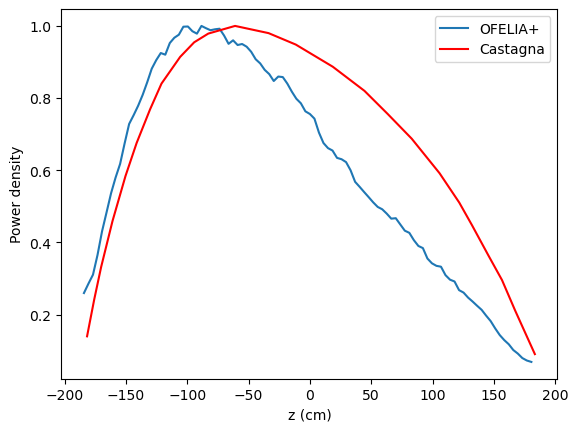

In [15]:
# slices = np.linspace(base_z, base_z + l_active,n_div)
# TT = TH.computeSolidAverageT_Z(vol_markers[0], T_sol, slices)

# fig, ax = plt.subplots(ncols = 3, figsize =(10,5))
# ax[0].scatter(x = slices[0:-1], y = TT)#average_T[0])
# ax[0].plot(castagna_res['fuel_temp'][:,0]-l_active/2,castagna_res['fuel_temp'][:,1], 'r')
# ax[0].set_ylabel("Average fuel Temperature (K)")
# #ax[1].scatter(x =slices[0:-1],y =average_T[1])
# ax[1].plot(castagna_res['coolant_temp'][:,0]-l_active/2,castagna_res['coolant_temp'][:,1])
# ax[1].set_ylabel("Average water Temperature (K)")
# ax[2].plot(z,q3_unrelaxed/np.max(q3_unrelaxed))
# ax[2].plot(castagna_res['fission_rate'][:,0]-l_active/2,castagna_res['fission_rate'][:,1]/np.max(castagna_res['fission_rate'][:,1]),'r')
# ax[2].set_ylabel("Power density")

# plt.tight_layout()

plt.plot(z,q3_unrelaxed/np.max(q3_unrelaxed), label='OFELIA+')
plt.plot(castagna_res['fission_rate'][:,0]-l_active/2,castagna_res['fission_rate'][:,1]/np.max(castagna_res['fission_rate'][:,1]),'r', label='Castagna')
plt.ylabel("Power density")
plt.xlabel("z (cm)")
plt.legend()
plt.savefig(path_res+'power_density.png')

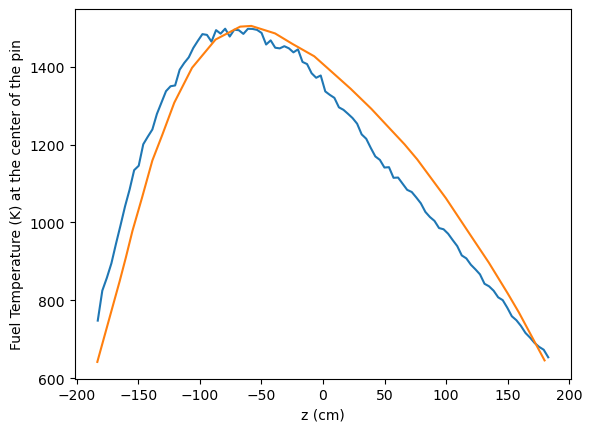

In [16]:
zz = np.zeros((3,100))
zz[2] = np.linspace(slices[0],slices[-1],100)
output_di_quella_funzione = dataOverLine(domain = domain, points = zz)

plt.plot(zz[2],T_sol.eval(*output_di_quella_funzione))
plt.plot(castagna_res['fuel_temp'][:,0]-l_active/2,castagna_res['fuel_temp'][:,1])
plt.ylabel("Fuel Temperature (K) at the center of the pin")
plt.xlabel("z (cm)")
plt.savefig(path_res+'fuel_temp.png')

In [17]:
print("maximum temperature: ", np.max(T_sol.x.array))
print("maximum temperature: ", np.max(castagna_res['fuel_temp'][:,1]))


maximum temperature:  1519.483460161903
maximum temperature:  1504.566870326379
